# 0 - Imports/Constants

In [1]:
import os
from dataclasses import dataclass
from collections import Counter

from xml.etree import ElementTree
from xml.etree.ElementTree import ParseError
from glob import glob
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchvision.transforms import transforms

import nltk

from tqdm import tqdm

# adding imports to match the ones from test.ipynb, where we will be sourcing some of the code from
import torch.nn.functional as F
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.pyplot import figure
import skimage.transform
import argparse

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# adding imports to match the ones from train.py
import time
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence
from models import Encoder, DecoderWithAttention
#from dataloader import *
from preproc import *
from nltk.translate.bleu_score import corpus_bleu

In [2]:
data_root_dir = '../data/iaprtc12/'
annotation_dir = os.path.join(data_root_dir, 'annotations_complete_eng/')
image_dir = os.path.join(data_root_dir, 'images/')

UNKNOWN_TOKEN = '<unk>'
START_TOKEN = '<start>'
END_TOKEN = '<end>'
PADDING_TOKEN = '<pad>'

In [3]:
hyperparameters = {
    'batch_size': 32
}

In [4]:
# visualization parameters
model_path = '../data/BEST_checkpoint_flickr8k_5_10.pth.tar'  # model path updated
word_map = '../data/wordmap_flickr8k_5_10.json'  # wordmap path updated
beam_size = 3
smooth = False

# 1 - Data loading 
This part is mostly done by Dominik, with individual contributions by Maria marked in the code.

In [5]:
@dataclass(slots=True, kw_only=True)
class CLEFSample:
    # by Dominik
    image_id: str
    caption: str
    caption_length: torch.CharTensor
    image_path: str
    encoded_caption: torch.IntTensor = None
    image: torch.FloatTensor = None


class CLEFDataset(Dataset):
    # by Dominik, individual contributions by Maria marked with in-line comments or comments under specific methods
    def __init__(
        self, 
        annotation_directory: str, 
        image_directory: str, 
        number_images=100, 
        word_map: dict = None, 
        min_frequency=10, 
        concat_captions: bool = False  # added by Maria to allow the optional concatenation of multiple captions into one
    ) -> None:
        super(CLEFDataset, self).__init__()
        captions = self._load_captions(annotation_directory, number_images, concat_captions)
        samples = self._load_images(image_directory, captions)

        if word_map == None:
            word_map = self._create_word_map(samples, min_frequency)
        self.word_map = word_map

        self.samples = self._encode_captions(samples)

    def _load_captions(self, directory: str, number_images: int, concat_captions: bool) -> list[CLEFSample]:
        captions: list[CLEFSample] = []

        file_pattern = directory + '**/*.eng'
        for file in glob(file_pattern, recursive=True):
            if len(captions) == number_images:
                break
            try:
                root = ElementTree.parse(file).getroot()
                description = root.find('./DESCRIPTION').text
                # multiple captions option by Maria
                all_captions = description.split(';')
                if concat_captions == True:
                    first_caption = ' and '.join(all_captions[:-1])  # if not -1, then there is a trailing 'and'
                else:
                    first_caption = all_captions[0]
                    
                tokenized_caption = nltk.word_tokenize(first_caption)
                
                image_path = root.find('./IMAGE').text.removeprefix('images/')
                image_id = image_path.removesuffix('.jpg')
                
                # selecting only the captions that include verbs or prepositions (relation words) by Maria
                annotated_caption = nltk.pos_tag(tokenized_caption, tagset='universal')

                va_counter = 0  # for seeing if there is a verb or an adposition in the description
                for tagged_word in annotated_caption:
                    if tagged_word[1] == 'VERB':
                        va_counter += 1
                    elif tagged_word[1] == 'ADP':
                        va_counter += 1
                    else:
                        continue
                
                if va_counter > 0:
                    captions.append(CLEFSample(
                        image_id=image_id,
                        caption=tokenized_caption,
                        # +2 for start and end token
                        caption_length=torch.CharTensor([len(tokenized_caption) + 2]),
                        image_path=image_path
                    ))
                else:
                    continue
                    
            except ParseError:
                continue
        
        print('Captions loaded!')  # added for clarity by Maria

        return captions

    def _load_images(self, directory: str, captions: list[CLEFSample]) -> list[CLEFSample]:
        transform = transforms.ToTensor()

        samples: list[CLEFSample] = []
        for sample in tqdm(captions, desc='Loading images...'):  # tqdm added because Maria is impatient
            image_path = os.path.join(directory, sample.image_path)

            # TODO correct conversion?
            # error-handling added by Maria
            try:
                image = Image.open(image_path).resize((256, 256)).convert('RGB')
                sample.image = transform(image)
                samples.append(sample)
            except FileNotFoundError:
                continue

        print('Images loaded!')  # added for clarity by Maria
        
        return samples

    def _create_word_map(self, samples: list[CLEFSample], min_frequency: int) -> dict:
        word_frequency = Counter()
        for sample in samples:
            word_frequency.update(sample.caption)

        words = [word for word in word_frequency.keys() if word_frequency[word] >= min_frequency]

        word_map = {word: index for index, word in enumerate(words, start=1)}
        word_map[UNKNOWN_TOKEN] = len(word_map) + 1
        word_map[START_TOKEN] = len(word_map) + 1
        word_map[END_TOKEN] = len(word_map) + 1
        word_map[PADDING_TOKEN] = 0

        return word_map

    def _encode_captions(self, samples: list[CLEFSample]) -> list[CLEFSample]:
        encoded_samples: list[CLEFSample] = []
        for sample in samples:
            encoding = [self.get_encoded_token(START_TOKEN), *[self.get_encoded_token(token)
                                                               for token in sample.caption], self.get_encoded_token(END_TOKEN)]
            sample.encoded_caption = torch.LongTensor(encoding)  # changing to LongTensor to match the model (Maria)
            encoded_samples.append(sample)
        return encoded_samples

    def get_encoded_token(self, token: str) -> int:
        if token in self.word_map:
            return self.word_map[token]
        else:
            return self.word_map[UNKNOWN_TOKEN]

    def __getitem__(self, index: int) -> CLEFSample:
        return self.samples[index]

    def __len__(self) -> int:
        return len(self.samples)


In [6]:
def custom_collate(samples: list[CLEFSample]) -> dict:
    # by Dominik
    image_ids = []
    captions = []
    caption_lengths = []
    encoded_captions = []
    image_paths = []
    images = []

    for sample in samples:
        image_ids.append(sample.image_id)
        captions.append(sample.caption)
        caption_lengths.append(sample.caption_length)
        encoded_captions.append(sample.encoded_caption)
        image_paths.append(sample.image_path)
        images.append(sample.image)
    
    return {
        'image_ids': image_ids,
        'captions': captions,
        'caption_lengths': caption_lengths,
        'encoded_captions': pad_sequence(encoded_captions, batch_first=True),
        'image_paths': image_paths,
        'images': images
    }

In [7]:
dataset = CLEFDataset(annotation_dir, image_dir, number_images=50, min_frequency=1, concat_captions=True)

Captions loaded!


Loading images...: 100%|███████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 190.28it/s]

Images loaded!


In [8]:
# splitting the dataset by Maria
# remove the last optional argument for random splits, this way the seed is fixed so results are reproducible
# QUESTION: does this need to be done any prettier?
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1], generator=torch.Generator().manual_seed(25))

In [9]:
# by Dominik
dataloader = DataLoader(
    train_set, 
    hyperparameters['batch_size'], 
    shuffle=True, 
    collate_fn=custom_collate, 
    drop_last=True  # added by Maria since we were told it is good to do so when working with LSTMs in the Machine Learning 2 course
)

In [10]:
for batch in dataloader:
    print(batch['image_paths'])

['00/692.jpg', '00/662.jpg', '00/674.jpg', '00/686.jpg', '00/679.jpg', '00/717.jpg', '00/664.jpg', '00/715.jpg', '00/704.jpg', '00/671.jpg', '00/709.jpg', '00/700.jpg', '00/66.jpg', '00/25.jpg', '00/694.jpg', '00/712.jpg', '00/693.jpg', '00/705.jpg', '00/116.jpg', '00/690.jpg', '00/663.jpg', '00/26.jpg', '00/676.jpg', '00/683.jpg', '00/708.jpg', '00/685.jpg', '00/49.jpg', '00/656.jpg', '00/687.jpg', '00/38.jpg', '00/682.jpg', '00/112.jpg']


# 2 - Testing the pretrained model (by Nikolai Ilinykh)
This part is mostly done by Nikolai, adapted for our use by Maria (changes marked by comments in the code), with individual contributions from Dominik marked in the code.

In [11]:
### THE FOLLOWING CODE IS TAKEN FROM TEST.IPYNB BY NIKOLAI ILINYKH

def caption_image_beam_search(encoder, decoder, image_path, word_map, beam_size=3):
    """
    Reads an image and captions it with beam search.

    :param encoder: encoder model
    :param decoder: decoder model
    :param image_path: path to image
    :param word_map: word map
    :param beam_size: number of sequences to consider at each decode-step
    :return: caption, weights for visualization
    """

    k = beam_size
    vocab_size = len(word_map)
    
    
    img = Image.open(image_path)
    img = img.resize((256, 256))
    img = np.transpose(img, (2, 0, 1))
    #img = img / 255.
    img = torch.FloatTensor(img).to(device)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([normalize])
    image = transform(img)  # (3, 256, 256)

    # Encode
    image = image.unsqueeze(0)  # (1, 3, 256, 256)
    encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim)
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    # Flatten encoding
    encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)

    # We'll treat the problem as having a batch size of k
    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)

    # Tensor to store top k previous words at each step; now they're just 
    k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)  # (k, 1)

    # Tensor to store top k sequences; now they're just 
    seqs = k_prev_words  # (k, 1)

    # Tensor to store top k sequences' scores; now they're just 0
    top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

    # Tensor to store top k sequences' alphas; now they're just 1s
    seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size).to(device)  # (k, 1, enc_image_size, enc_image_size)

    # Lists to store completed sequences, their alphas and scores
    complete_seqs = list()
    complete_seqs_alpha = list()
    complete_seqs_scores = list()

    # Start decoding
    step = 1
    h, c = decoder.init_hidden_state(encoder_out)

    # s is a number less than or equal to k, because sequences are removed from this process once they hit 
    while True:

        embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (s, embed_dim)

        awe, alpha = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels)

        alpha = alpha.view(-1, enc_image_size, enc_image_size)  # (s, enc_image_size, enc_image_size)

        gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (s, encoder_dim)
        awe = gate * awe

        h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))  # (s, decoder_dim)

        scores = decoder.fc(h)  # (s, vocab_size)
        scores = F.log_softmax(scores, dim=1)

        # Add
        scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)

        # For the first step, all k points will have the same scores (since same k previous words, h, c)
        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
        else:
            # Unroll and find top scores, and their unrolled indices
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

        # Convert unrolled indices to actual indices of scores
        prev_word_inds = top_k_words / vocab_size  # (s)
        next_word_inds = top_k_words % vocab_size  # (s)

        
        
        
        # Add new words to sequences, alphas

        prev_word_inds = prev_word_inds.cpu()
        prev_word_inds = prev_word_inds.long()        

        seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)
        
        
        seqs_alpha = torch.cat([seqs_alpha[prev_word_inds], alpha[prev_word_inds].unsqueeze(1)],
                               dim=1)  # (s, step+1, enc_image_size, enc_image_size)

        # Which sequences are incomplete (didn't reach )?
        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                           next_word != word_map['<end>']]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        # Set aside complete sequences
        if len(complete_inds) > 0:
            complete_seqs.extend(seqs[complete_inds].tolist())
            complete_seqs_alpha.extend(seqs_alpha[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
        k -= len(complete_inds)  # reduce beam length accordingly

        # Proceed with incomplete sequences
        if k == 0:
            break
        seqs = seqs[incomplete_inds]
        seqs_alpha = seqs_alpha[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds]]
        c = c[prev_word_inds[incomplete_inds]]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        # Break if things have been going on too long
        if step > 50:
            break
        step += 1

    i = complete_seqs_scores.index(max(complete_seqs_scores))
    seq = complete_seqs[i]
    alphas = complete_seqs_alpha[i]

    return seq, alphas


def visualize_att(image_path, seq, alphas, rev_word_map, smooth=False):
    """
    Visualizes caption with weights at every word.

    Adapted from paper authors' repo: https://github.com/kelvinxu/arctic-captions/blob/master/alpha_visualization.ipynb

    :param image_path: path to image that has been captioned
    :param seq: caption
    :param alphas: weights
    :param rev_word_map: reverse word mapping, i.e. ix2word
    :param smooth: smooth weights?
    """
    
    figure(figsize=(10, 8), dpi=80)
    
    image = Image.open(image_path)
    image = image.resize([24 * 38, 24 * 38], Image.LANCZOS)

    words = [rev_word_map[ind] for ind in seq]

    for t in range(len(words)):
        if t > 50:
            break
        plt.subplot(int(np.ceil(len(words) / 5.)), 5, t + 1)

        plt.text(0, 1, '%s' % (words[t]), color='black', backgroundcolor='white', fontsize=12)
        plt.imshow(image)
        current_alpha = alphas[t, :]
        if smooth:
            alpha = skimage.transform.pyramid_expand(current_alpha.numpy(), upscale=12, sigma=8)
        else:
            alpha = skimage.transform.resize(current_alpha.numpy(), [24 * 38, 24 * 38])
        if t == 0:
            plt.imshow(alpha, alpha=0)
        else:
            plt.imshow(alpha, alpha=0.6)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
    plt.show()

In [12]:
def test_images(model_path, word_map, img, beam_size, smooth):
    # turning a piece of code by Nikolai from test.ipynb into a function
    # Load model
    checkpoint = torch.load(model_path, map_location=str(device))
    decoder = checkpoint['decoder']
    decoder = decoder.to(device)
    decoder.eval()
    encoder = checkpoint['encoder']
    encoder = encoder.to(device)
    encoder.eval()

    # Load word map (word2ix)
    with open(word_map, 'r') as j:
        word_map = json.load(j)
    rev_word_map = {v: k for k, v in word_map.items()}  # ix2word

    # Encode, decode with attention and beam search
    seq, alphas = caption_image_beam_search(encoder, decoder, img, word_map, beam_size)
    alphas = torch.FloatTensor(alphas)

    # Visualize caption and attention of best sequence
    visualize_att(img, seq, alphas, rev_word_map, smooth)

In [13]:
# creating a dataloader for testing purposes, batch size 1 for ease of testing, no shuffle is needed, no drop last is needed
test_dataloader = DataLoader(
    test_set, 
    1, 
    shuffle=False, 
    collate_fn=custom_collate, 
)

Generating captions and attention...:   0%|                                                       | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_342/2160579877.py:23: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  img = torch.FloatTensor(img).to(device)
/tmp/ipykernel_342/2160579877.py:159: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image = image.resize([24 * 38, 24 * 38], Image.LANCZOS)


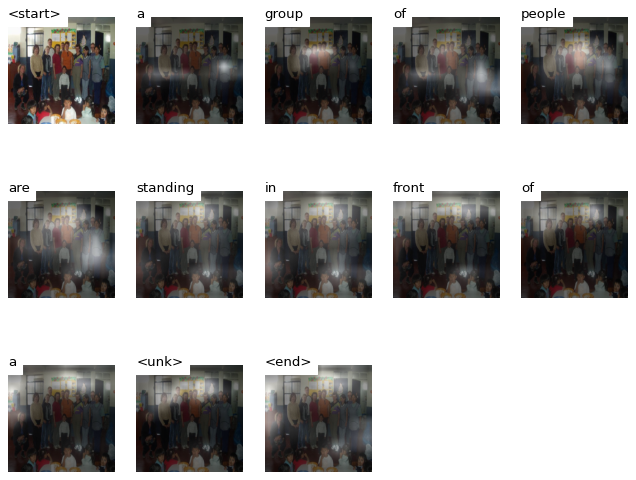

Generating captions and attention...:  20%|█████████▍                                     | 1/5 [00:03<00:12,  3.08s/it]

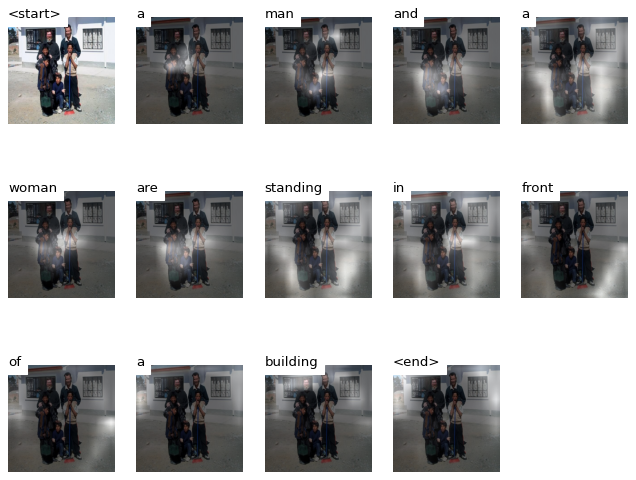

Generating captions and attention...:  40%|██████████████████▊                            | 2/5 [00:05<00:08,  2.94s/it]

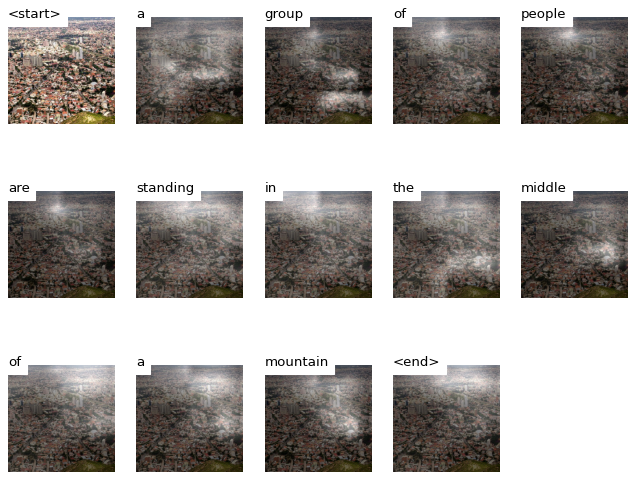

Generating captions and attention...:  60%|████████████████████████████▏                  | 3/5 [00:08<00:05,  2.76s/it]

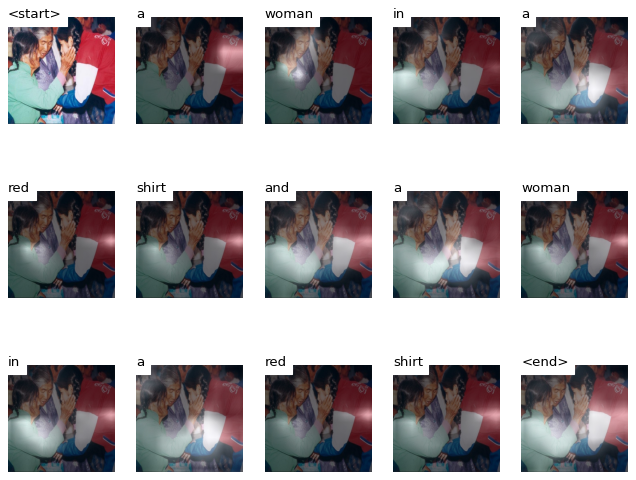

Generating captions and attention...:  80%|█████████████████████████████████████▌         | 4/5 [00:11<00:02,  2.82s/it]

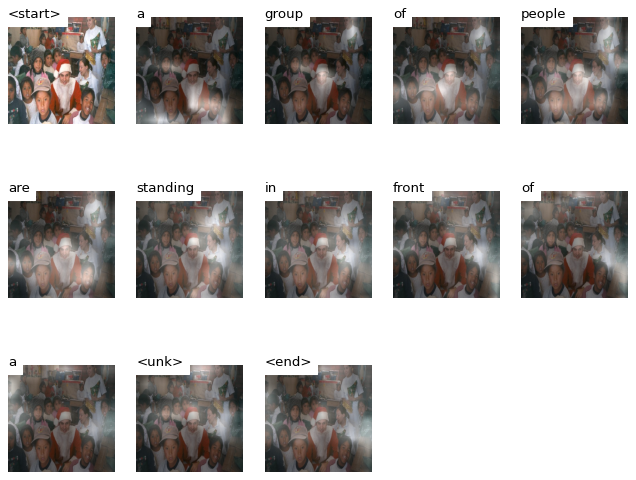

Generating captions and attention...: 100%|███████████████████████████████████████████████| 5/5 [00:13<00:00,  2.72s/it]


In [14]:
# generating captions and descriptions for every image in the test dataloader
# in the future can regulate which ones get generated and displayed with if statements
for batch in tqdm(test_dataloader, desc='Generating captions and attention...'):
    img = os.path.join(image_dir, batch['image_paths'][0])
    test_images(model_path, word_map, img, beam_size, smooth)

# 3 - Fine-tuning the model (by Nikolai Ilinykh)
This part is mostly done by Nikolai, adapted for our use by Maria (changes marked by comments in the code), with individual contributions from Dominik marked in the code.

In [24]:
# this is all from Nikolai
def train(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, epoch):
    """
    Performs one epoch's training.
    :param train_loader: DataLoader for training data
    :param encoder: encoder model
    :param decoder: decoder model
    :param criterion: loss layer
    :param encoder_optimizer: optimizer to update encoder's weights (if fine-tuning)
    :param decoder_optimizer: optimizer to update decoder's weights
    :param epoch: epoch number
    """

    decoder.train()  # train mode (dropout and batchnorm is used)
    encoder.train()

    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    losses = AverageMeter()  # loss (per word decoded)
    top5accs = AverageMeter()  # top5 accuracy

    start = time.time()

    # Batches
    for i, content in enumerate(train_loader):  # changing to fit our dataloader, TODO same in validation
        imgs = torch.stack(content['images'])
        caps = content['encoded_captions']
        caplens = torch.stack(content['caption_lengths'])
        data_time.update(time.time() - start)

        # Move to GPU, if available
        imgs = imgs.to(device)
        caps = caps.to(device)
        caplens = caplens.to(device)

        # Forward prop.
        imgs = encoder(imgs)
        scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

        # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
        targets = caps_sorted[:, 1:]

        # Remove timesteps that we didn't decode at, or are pads
        # pack_padded_sequence is an easy trick to do this
        # useful tutorial: https://gist.github.com/HarshTrivedi/f4e7293e941b17d19058f6fb90ab0fec
        scores, *_ = pack_padded_sequence(scores, decode_lengths, batch_first=True)
        targets, *_ = pack_padded_sequence(targets, decode_lengths, batch_first=True)

        # Calculate loss
        loss = criterion(scores, targets)

        # Add doubly stochastic attention regularization
        loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

        # Back prop.
        decoder_optimizer.zero_grad()
        if encoder_optimizer is not None:
            encoder_optimizer.zero_grad()
        loss.backward()

        # Clip gradients
        if grad_clip is not None:
            clip_gradient(decoder_optimizer, grad_clip)
            if encoder_optimizer is not None:
                clip_gradient(encoder_optimizer, grad_clip)

        # Update weights
        decoder_optimizer.step()
        if encoder_optimizer is not None:
            encoder_optimizer.step()

        # Keep track of metrics
        top5 = accuracy(scores, targets, 5)
        losses.update(loss.item(), sum(decode_lengths))
        top5accs.update(top5, sum(decode_lengths))
        batch_time.update(time.time() - start)

        start = time.time()

        # Print status
        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data Load Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})'.format(epoch, i, len(train_loader),
                                                                          batch_time=batch_time,
                                                                          data_time=data_time, loss=losses,
                                                                          top5=top5accs))


def validate(val_loader, encoder, decoder, criterion):
    """
    Performs one epoch's validation.
    :param val_loader: DataLoader for validation data.
    :param encoder: encoder model
    :param decoder: decoder model
    :param criterion: loss layer
    :return: BLEU-4 score
    """
    decoder.eval()  # eval mode (no dropout or batchnorm)
    if encoder is not None:
        encoder.eval()

    batch_time = AverageMeter()
    losses = AverageMeter()
    top5accs = AverageMeter()

    start = time.time()

    references = list()  # references (true captions) for calculating BLEU-4 score
    hypotheses = list()  # hypotheses (predictions)

    # explicitly disable gradient calculation to avoid CUDA memory error
    # solves the issue #57
    with torch.no_grad():
        # Batches
        for i, content in enumerate(val_loader):  # changing to fit our dataloader
            imgs = torch.stack(content['images'])
            caps = content['encoded_captions']
            caplens = torch.stack(content['caption_lengths'])

            # Move to device, if available
            imgs = imgs.to(device)
            caps = caps.to(device)
            caplens = caplens.to(device)

            # Forward prop.
            if encoder is not None:
                imgs = encoder(imgs)
            scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

            # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
            targets = caps_sorted[:, 1:]

            # Remove timesteps that we didn't decode at, or are pads
            # pack_padded_sequence is an easy trick to do this
            scores_copy = scores.clone()
            scores, *_ = pack_padded_sequence(scores, decode_lengths, batch_first=True)
            targets, *_ = pack_padded_sequence(targets, decode_lengths, batch_first=True)

            # Calculate loss
            loss = criterion(scores, targets)

            # Add doubly stochastic attention regularization
            loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

            # Keep track of metrics
            losses.update(loss.item(), sum(decode_lengths))
            top5 = accuracy(scores, targets, 5)
            top5accs.update(top5, sum(decode_lengths))
            batch_time.update(time.time() - start)

            start = time.time()

            if i % print_freq == 0:
                print('Validation: [{0}/{1}]\t'
                      'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})\t'.format(i, len(val_loader), batch_time=batch_time,
                                                                                loss=losses, top5=top5accs))

            # Store references (true captions), and hypothesis (prediction) for each image
            # If for n images, we have n hypotheses, and references a, b, c... for each image, we need -
            # references = [[ref1a, ref1b, ref1c], [ref2a, ref2b], ...], hypotheses = [hyp1, hyp2, ...]

            # References
            allcaps = allcaps[sort_ind]  # because images were sorted in the decoder
            for j in range(allcaps.shape[0]):
                img_caps = allcaps[j].tolist()
                img_captions = list(
                    map(lambda c: [w for w in c if w not in {word_map['<start>'], word_map['<pad>']}],
                        img_caps))  # remove <start> and pads
                references.append(img_captions)

            # Hypotheses
            _, preds = torch.max(scores_copy, dim=2)
            preds = preds.tolist()
            temp_preds = list()
            for j, p in enumerate(preds):
                temp_preds.append(preds[j][:decode_lengths[j]])  # remove pads
            preds = temp_preds
            hypotheses.extend(preds)

            assert len(references) == len(hypotheses)
        print(references)
        print(hypotheses)
        # Calculate BLEU-4 scores
        bleu4 = corpus_bleu(references, hypotheses)

        print(
            '\n * LOSS - {loss.avg:.3f}, TOP-5 ACCURACY - {top5.avg:.3f}, BLEU-4 - {bleu}\n'.format(
                loss=losses,
                top5=top5accs,
                bleu=bleu4))

    return bleu4

In [27]:
# Model parameters
emb_dim = 512  # dimension of word embeddings
attention_dim = 512  # dimension of attention linear layers
decoder_dim = 512  # dimension of decoder RNN
dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # sets device for model and PyTorch tensors
cudnn.benchmark = True  # set to true only if inputs to model are fixed size; otherwise lot of computational overhead

# Training parameters
start_epoch = 0
epochs = 120  # number of epochs to train for (if early stopping is not triggered)
epochs_since_improvement = 0  # keeps track of number of epochs since there's been an improvement in validation BLEU
batch_size = 32
workers = 1  # for data-loading; right now, only 1 works with h5py
encoder_lr = 1e-4  # learning rate for encoder if fine-tuning
decoder_lr = 4e-4  # learning rate for decoder
grad_clip = 5.  # clip gradients at an absolute value of
alpha_c = 1.  # regularization parameter for 'doubly stochastic attention', as in the paper
best_bleu4 = 0.  # BLEU-4 score right now
print_freq = 100  # print training/validation stats every __ batches
fine_tune_encoder = False  # fine-tune encoder?
checkpoint = '../data/BEST_checkpoint_flickr8k_5_10.pth.tar'  # path to checkpoint, None if none


def main():
    """
    Training and validation.
    """

    global best_bleu4, epochs_since_improvement, checkpoint, start_epoch, fine_tune_encoder, data_name, word_map

    # Read word map
    word_map_file = '../data/wordmap_flickr8k_5_10.json'
    with open(word_map_file, 'r') as j:
        word_map = json.load(j)

#removing initializing model

    checkpoint = torch.load(checkpoint, map_location=torch.device(device))
    start_epoch = checkpoint['epoch'] + 1
    epochs_since_improvement = checkpoint['epochs_since_improvement']
    best_bleu4 = checkpoint['bleu-4']
    decoder = checkpoint['decoder']
    decoder_optimizer = checkpoint['decoder_optimizer']
    encoder = checkpoint['encoder']
    encoder_optimizer = checkpoint['encoder_optimizer']
    if fine_tune_encoder is True and encoder_optimizer is None:
        encoder.fine_tune(fine_tune_encoder)
        encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                            lr=encoder_lr)

    # Move to GPU, if available
    decoder = decoder.to(device)
    encoder = encoder.to(device)

    # Loss function
    criterion = nn.CrossEntropyLoss().to(device)

    # Custom dataloaders
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    train_loader = torch.utils.data.DataLoader(
        train_set,  
        shuffle=True, 
        collate_fn=custom_collate, 
        drop_last=True,
        batch_size=batch_size, num_workers=workers, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(
        train_set,  # change to val_set later!!!  
        shuffle=True, 
        collate_fn=custom_collate, 
        drop_last=True,
        batch_size=batch_size, num_workers=workers, pin_memory=True)

    # Epochs
    for epoch in range(start_epoch, epochs):

        # Decay learning rate if there is no improvement for 8 consecutive epochs, and terminate training after 20
        if epochs_since_improvement == 20:
            break
        if epochs_since_improvement > 0 and epochs_since_improvement % 8 == 0:
            adjust_learning_rate(decoder_optimizer, 0.8)
            if fine_tune_encoder:
                adjust_learning_rate(encoder_optimizer, 0.8)

        # One epoch's training
        train(train_loader=train_loader,
              encoder=encoder,
              decoder=decoder,
              criterion=criterion,
              encoder_optimizer=encoder_optimizer,
              decoder_optimizer=decoder_optimizer,
              epoch=epoch)

        # One epoch's validation
        recent_bleu4 = validate(val_loader=val_loader,
                                encoder=encoder,
                                decoder=decoder,
                                criterion=criterion)

        # Check if there was an improvement
        is_best = recent_bleu4 > best_bleu4
        best_bleu4 = max(recent_bleu4, best_bleu4)
        if not is_best:
            epochs_since_improvement += 1
            print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))
        else:
            epochs_since_improvement = 0

        # Save checkpoint
        save_checkpoint(data_name, epoch, epochs_since_improvement, encoder, decoder, encoder_optimizer,
                        decoder_optimizer, recent_bleu4, is_best)

In [28]:
main()

Epoch: [6][0/1]	Batch Time 22.366 (22.366)	Data Load Time 0.411 (0.411)	Loss 10.0397 (10.0397)	Top-5 Accuracy 4.226 (4.226)
Validation: [0/1]	Batch Time 10.648 (10.648)	Loss 8.9103 (8.9103)	Top-5 Accuracy 4.262 (4.262)	


UnboundLocalError: local variable 'allcaps' referenced before assignment